# Build with Feature Extraction and Logistic Regression and Predict on Foursquare Data


BUILD: Create a data model
- Selecting the appropriate model
- Building a model
- Testing and training our model
- Evaluating and refining our model



PREDICT: Predict on new data from foursquare API 
- loading the cleaned data from csv file
- using the trained model create predictions 
- create visualisations to answer my question

In [1]:
import pandas as pd
import numpy as np

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Loading the Training Dataset

Training:
- polarity : Target 2:positive, 1:neutral, 0:negative
- words : preprocessed sentences
- type : the tags of the words from lemmatizing 

In [2]:
training = pd.read_csv('training_bs.csv', encoding='utf8')
training.head()

,sentence,sentiment,lem_words,lem_tags,word_tags
0,Amma is nothing special.,1,amma be nothing special,NN VB NN JJ,"[amma/NN, be/VB, nothing/NN, special/JJ]"
1,we were tired and cold when we got to the rest...,1,be tired cold get restaurant then sit begin or...,VB JJ JJ VB NN RB VB VB VB NN,"[be/VB, tired/JJ, cold/JJ, get/VB, restaurant/..."
2,When I'm feeling stressed by the noise and con...,1,feeling stress noise congestion office head ca...,NN VB NN NN NN NN NN NN NN,"[feeling/NN, stress/VB, noise/NN, congestion/N..."
3,"Anyways, if you're in the neighborhood to eat ...",1,re neighborhood eat good food wouldn waste tim...,NN NN VB JJ NN VB VB NN VB VB NN RB VB NN VB,"[re/NN, neighborhood/NN, eat/VB, good/JJ, food..."
4,we were tired and cold when we got to the rest...,1,be tired cold get restaurant then sit begin or...,VB JJ JJ VB NN RB VB VB VB NN,"[be/VB, tired/JJ, cold/JJ, get/VB, restaurant/..."


### Check for null values

In [3]:
training.isnull().sum()

sentence     0
sentiment    0
lem_words    0
lem_tags     0
word_tags    0
dtype: int64

### Set up X and y

In [4]:
X_train = training['lem_words']
y_train = training['sentiment']

print(X_train.shape)
print(y_train.shape)

(2400,)
(2400,)


### Baseline Accuracy
the baseline accuracy is 0.3

baseline_accuracy = majority class N / total N


In [5]:
print(y_train.value_counts(normalize=True))
baseline = 0.3

1    0.333333
2    0.333333
0    0.333333
Name: sentiment, dtype: float64


## Comparing Count Vec and TFIDF
- Count Vectorizer 
- TFIDF Vectorizer 
- Logistic Regression is the classifier used.. very fast classifier???

In [6]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

lr = LogisticRegression(random_state=1)

##### Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
# initalise the vectoriser 
cvec = CountVectorizer()
# fit the training data on the model
cvec.fit(X_train)

#transform training data into sparse matrix
X_train_cvec = cvec.transform(X_train)

# cross val score/ predict
cvec_score = cross_val_score(lr, X_train_cvec, y_train, cv=3 )


##### TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
# initalise the vectoriser 
tvec = TfidfVectorizer()
# fit the training data on the model
tvec.fit(X_train)

#transform training data into sparse matrix
X_train_tvec = tvec.transform(X_train)

# cross val score/ predict
tvec_score = cross_val_score(lr, X_train_tvec, y_train, cv=3)

### Comparing scores
- Both vectorizers increased the accuracy from the baseline
- Count Vectorizer highest score
- Hyperparameters will be further tested for the Count Vec


In [7]:
print('Baseline:', baseline)
print('Tfidf Vectorizer Score:', tvec_score.mean())
print('Count Vectorizer Score:', cvec_score.mean())
acc_list = []
acc_list.append(cvec_score.mean())
acc_list.append(tvec_score.mean())

# DataFrame Accuracy 
acc_df = pd.DataFrame()
acc_df['params']= ['cvec', 'tvec']
acc_df['scores']= acc_list
acc_df

Baseline: 0.3
Tfidf Vectorizer Score: 0.8737499999999999
Count Vectorizer Score: 0.8920833333333333


,params,scores
0,cvec,0.892083
1,tvec,0.873750


# EDA of Count Vectorizer


#### Word Frequency 
matrix outputting the 10 most common words and how many times they appear 
- Feature matrix of word occurences 
- top 10 word most occuring words
- most important words

In [8]:
df_cvec = pd.DataFrame(X_train_cvec.todense(),columns=cvec.get_feature_names())
word_freq = df_cvec.sum(axis=0).sort_values(ascending=False)
word_freq[:10]

be            1809
have           431
food           388
not            275
place          255
restaurant     235
good           228
service        224
go             190
great          189
dtype: int64

In [12]:
df_cvec['sentiment'] = y_train

In [15]:
for i in range(3):
    word_freq_class = df_cvec[(df_cvec.sentiment==i).values]
    word_freq_class_drop = word_freq_class.drop(['sentiment'], axis=1).sum(axis=0)
    order_word_freq_class_drop =  word_freq_class_drop.sort_values(ascending=False)
    print('Word Frequency for sentiment class '+ str(i))
    print(order_word_freq_class_drop[:10])


Word Frequency for sentiment class 0
be            768
have          146
not           144
food          120
service        87
good           73
place          68
restaurant     60
get            52
just           50
dtype: int64
Word Frequency for sentiment class 1
be            437
have          142
restaurant    114
food          113
go             90
not            89
place          85
friend         62
just           61
time           56
dtype: int64
Word Frequency for sentiment class 2
be            604
food          155
have          143
great         118
place         102
service       100
good           99
go             63
restaurant     61
very           52
dtype: int64


#### COUNT VEC - Zipf's law
Zipf’s Law states that the frequency of a word in a corpus is inversely proportional to its rank in the frequency table. This means that there the most frequent word is used twice as often as the second most frequent and so on. 

When Plotting the word frequency distribution Zipf's law does not fully apply as the cleaning process removed stop words (which are the most commonly used words)


But we can't really draw any conclusions from the latter, we expect the reviews to allude to complaints on the matter of time and their order, but at this stage we don't have enough evidence to suggest these words are being used negatively.

For this reason, this report will need to consider using n_grams in order to batch together possible adjectives to the noun such as 'bad'+'service'. This is necessary for words like 'really' which can only truly have sentiment towards negative or positive with a noun.

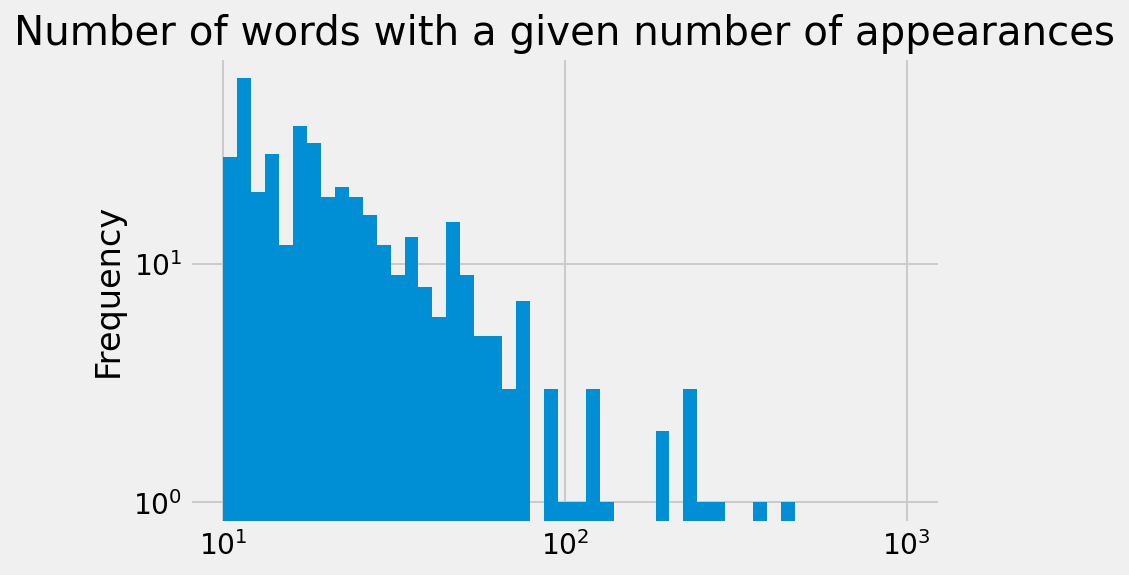

In [16]:
import matplotlib.pyplot as plt
word_freq.plot(kind='hist',
                       bins=np.logspace(1,3,50),
                       loglog=True,
                       title='Number of words with a given number of appearances',
                       fontsize=14)
plt.show()


# Tuning Hyperparameters Count Vectorizer 


In [17]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

### N_gram

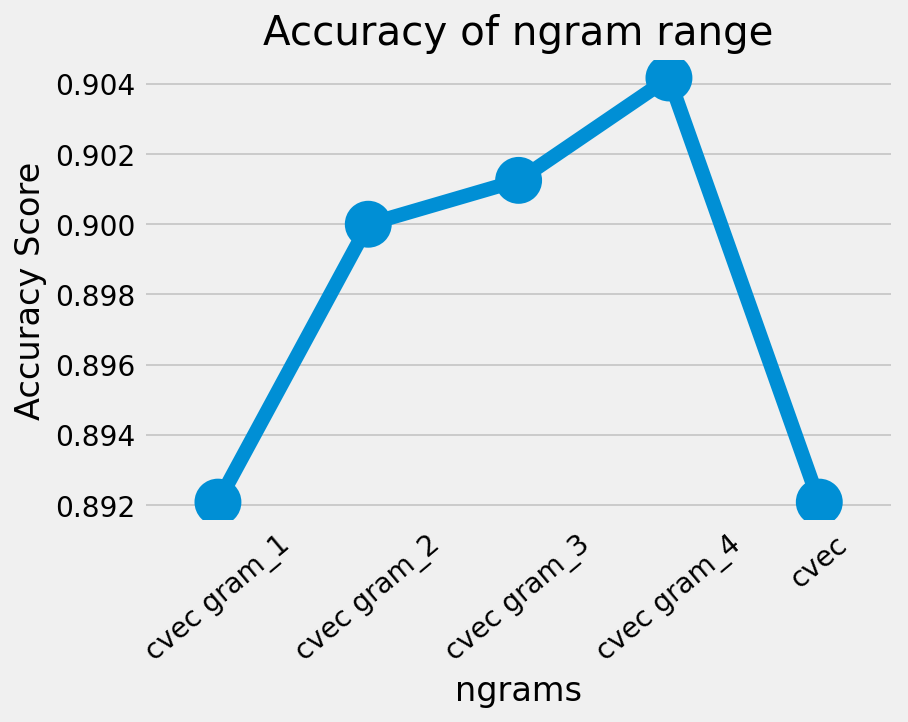

In [18]:
def count_vec_ngram(params, X_train, y_train):
    cvec_p = CountVectorizer(ngram_range=(params)) 

    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)

    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)

    # cross validation 
    return cvec_score_p.mean()

params = [(1,1), (1,2),(1,3), (1,4)] 
ngram_scores = []
for p in params:
    ngram_scores.append(count_vec_ngram(p, X_train, y_train))
    
ngrams = ['cvec gram_1','cvec gram_2','cvec gram_3','cvec gram_4']
ngram_df = pd.DataFrame({'params':ngrams, 'scores':ngram_scores}, index=[0,1,2,3])
# adding cvec score with default params
ngram_df = ngram_df.append(acc_df.iloc[:1,:])

# plot scores on graph
sns.pointplot(x='params', y='scores', data =ngram_df)
plt.ylabel('Accuracy Score')
plt.xlabel('ngrams')
plt.xticks(rotation=40)
plt.title('Accuracy of ngram range')
plt.show()

In [19]:
# update accuracy scores with highest score for 1,2 ngram
acc_df1 = acc_df.append(ngram_df.iloc[3,:])
acc_df1.reset_index(inplace=True, drop=True)
acc_df1

,params,scores
0,cvec,0.892083
1,tvec,0.873750
2,cvec gram_4,0.904167


### Max Features

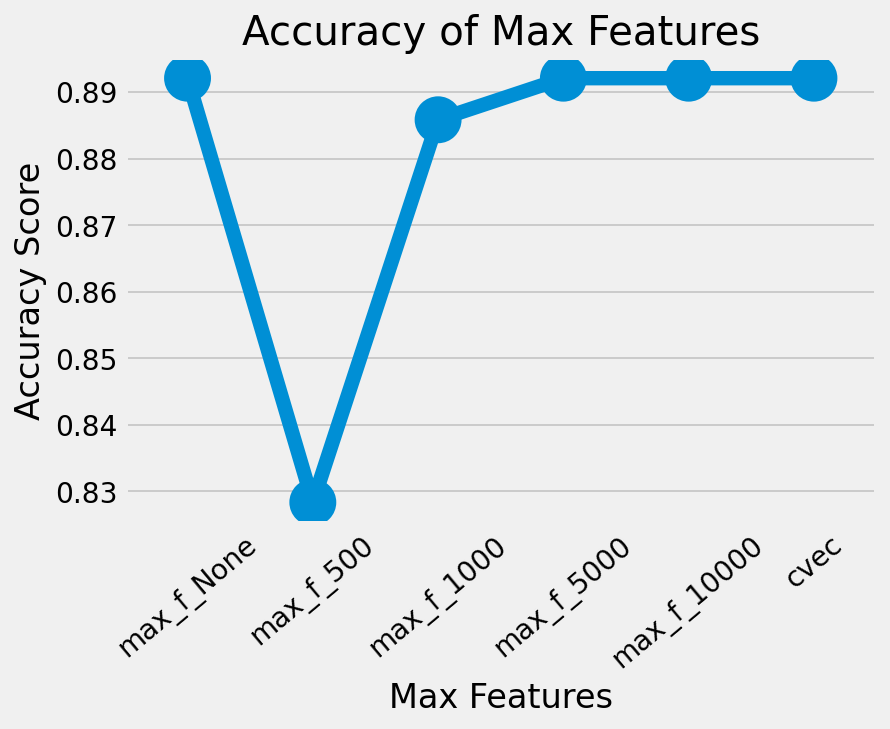

In [20]:
def count_vec_max_features(params, X_train, y_train):
    cvec_p = CountVectorizer(max_features=params) 

    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)

    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)

    # cross validation 
    return cvec_score_p.mean()

mf_params = [None, 500, 1000, 5000, 10000]
max_features_scores = [count_vec_max_features(p, X_train, y_train) for p in mf_params]
max_features = ['max_f_'+str(p) for p in mf_params]

# dataframe for scores
max_features_df = pd.DataFrame({'params':max_features, 'scores':max_features_scores}, index=[0,1,2,3,4])
# adding cvec score with default params
max_features_df = max_features_df.append(acc_df.iloc[:1,:])

sns.pointplot(x='params', y='scores', data =max_features_df)
plt.ylabel('Accuracy Score')
plt.xlabel('Max Features')
plt.xticks(rotation=40)
plt.title('Accuracy of Max Features')
plt.show()

In [21]:
# update accuracy dataframe with 3 highest scores
acc_df2 = acc_df1.append(max_features_df.drop(max_features_df.index[[1,2]]))
acc_df2.reset_index(inplace=True, drop=True)
acc_df2

,params,scores
0,cvec,0.892083
1,tvec,0.873750
2,cvec gram_4,0.904167
3,max_f_None,0.892083
4,max_f_5000,0.892083
5,max_f_10000,0.892083
6,cvec,0.892083


### max_df

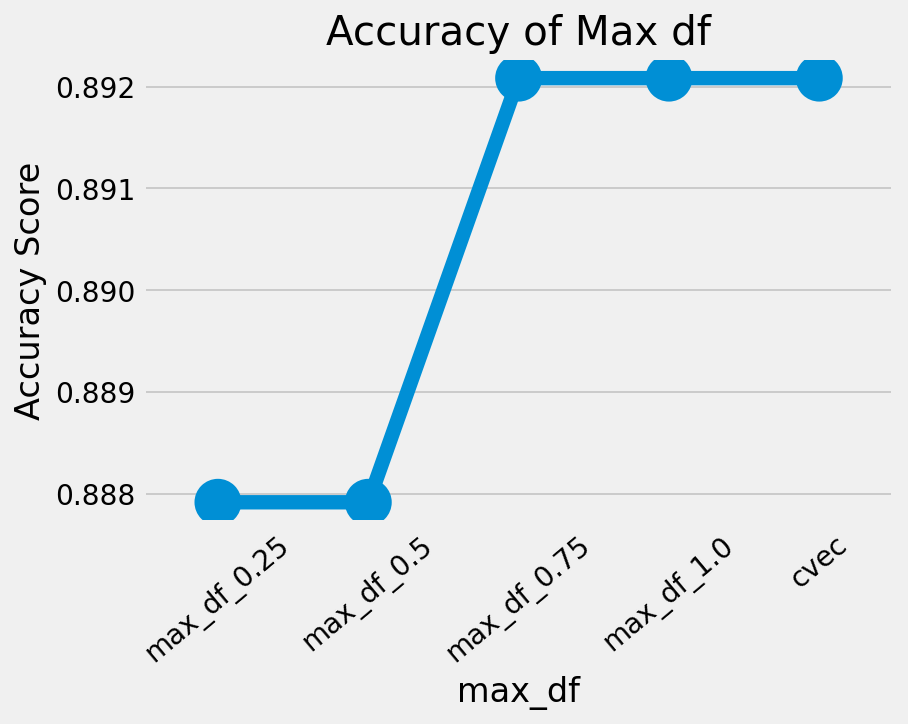

In [22]:
def count_vec_max_df(params, X_train, y_train):
    cvec_p = CountVectorizer(max_df=params) 

    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)

    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)

    # cross validation 
    return cvec_score_p.mean()

mdf_params = [0.25, 0.5, 0.75, 1.0]
max_df_scores = [count_vec_max_df(p, X_train, y_train) for p in mdf_params]
max_df = ['max_df_'+str(p) for p in mdf_params]

# dataframe for scores
max_df_df = pd.DataFrame({'params':max_df, 'scores':max_df_scores}, index=[0,1,2,3])
# adding cvec score with default params
max_df_df = max_df_df.append(acc_df.iloc[:1,:])

sns.pointplot(x='params', y='scores', data =max_df_df)
plt.ylabel('Accuracy Score')
plt.xlabel('max_df')
plt.xticks(rotation=40)
plt.title('Accuracy of Max df')
plt.show()

In [23]:
# update accuracy dataframe
acc_df3 = acc_df2.append(max_df_df.iloc[:2,:])
acc_df3.reset_index(inplace=True, drop=True)
acc_df3

,params,scores
0,cvec,0.892083
1,tvec,0.873750
2,cvec gram_4,0.904167
3,max_f_None,0.892083
4,max_f_5000,0.892083
5,max_f_10000,0.892083
6,cvec,0.892083
7,max_df_0.25,0.887917
8,max_df_0.5,0.887917


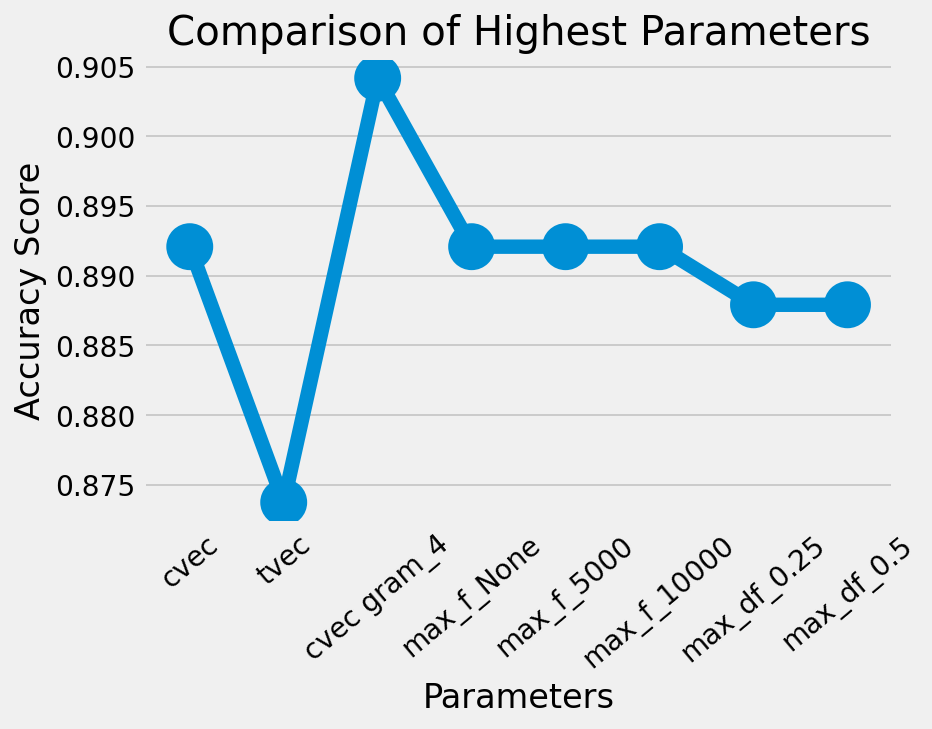

In [24]:
sns.pointplot(x='params', y='scores', data =acc_df3)
plt.ylabel('Accuracy Score')
plt.xlabel('Parameters')
plt.xticks(rotation=40)
plt.title('Comparison of Highest Parameters')
plt.show()

# Perform Count Vectorizer with chosen parameters
- ngram_range = (1,2): Bigram had the highest score
- max_features: will not be used as the highest scores were the same as default params. 
- max_df =  0.25: Both 0.25 and 0.5 gave the same score. The general trend of this param is the lower the threshold the higher the score. so between the 0.5 and 0.25 the lowest is chosen

In [25]:
##### Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
# initalise the vectoriser 
cvec_b = CountVectorizer(ngram_range=(1,4), max_df=0.25)
# fit the training data on the model
cvec_b.fit(X_train)

#transform training data into sparse matrix
X_train_cvec = cvec_b.transform(X_train)

# cross val score/ predict
cvec_score = cross_val_score(lr, X_train_cvec, y_train, cv=3)
cvec_score.mean()


acc_df3.loc[8]= ['best_params', cvec_score.mean()]
acc_df3.sort_values('scores', ascending=False)


,params,scores
2,cvec gram_4,0.904167
8,best_params,0.902500
0,cvec,0.892083
3,max_f_None,0.892083
4,max_f_5000,0.892083
5,max_f_10000,0.892083
6,cvec,0.892083
7,max_df_0.25,0.887917
1,tvec,0.873750


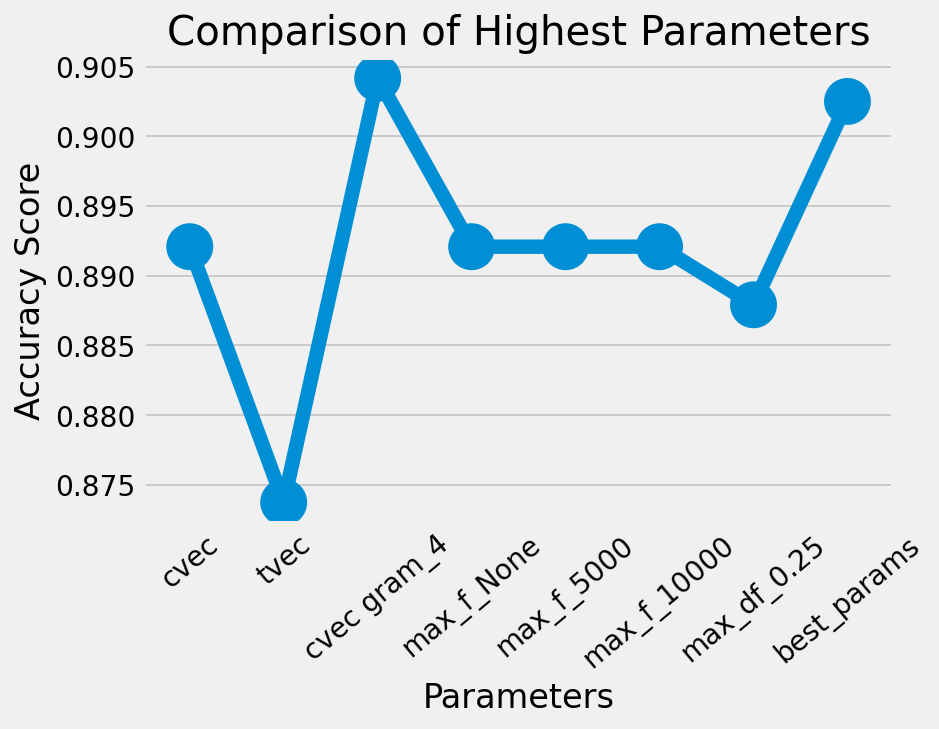

In [26]:
sns.pointplot(x='params', y='scores', data =acc_df3)
plt.ylabel('Accuracy Score')
plt.xlabel('Parameters')
plt.xticks(rotation=40)
plt.title('Comparison of Highest Parameters')
plt.show()

# Highest Score of Feature Transform Optimization
- As shown above the combined best parameters higher score

## Logistic Regression Parameters
- l1 and l2 regulization penalties

In [27]:
# Transform features once!
cvec_p = CountVectorizer(ngram_range=(1,4)) 
cvec_p.fit(X_train)
X_train_cvec_p = cvec_p.transform(X_train)

In [28]:
from sklearn.linear_model import LogisticRegressionCV
model_l1 = LogisticRegressionCV(Cs=np.logspace(-10,10,21),penalty = 'l1',solver='liblinear',cv=3) 
model_l1.fit(X_train_cvec_p, y_train)

/home/oleg/Programs/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LogisticRegressionCV(Cs=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                     cv=3, penalty='l1', solver='liblinear')

In [29]:
model_l2 = LogisticRegressionCV(Cs=np.logspace(-10,10,21), penalty = 'l2',solver='liblinear',cv=3) 
model_l2.fit(X_train_cvec_p, y_train)

LogisticRegressionCV(Cs=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
                     cv=3, solver='liblinear')

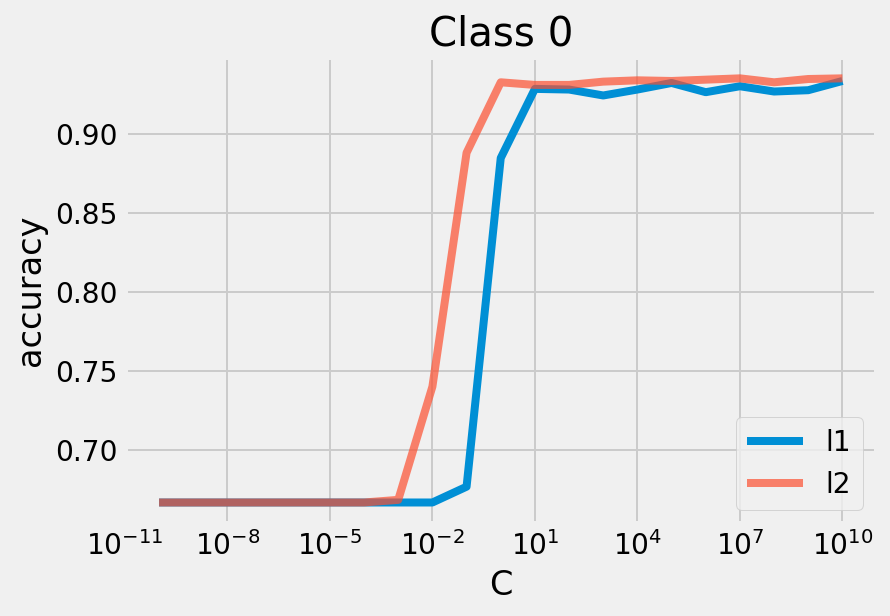

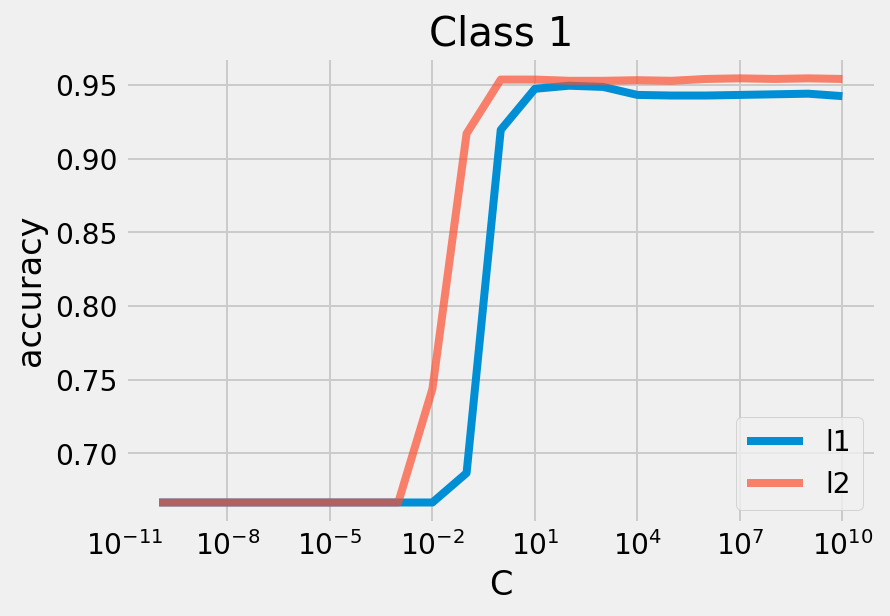

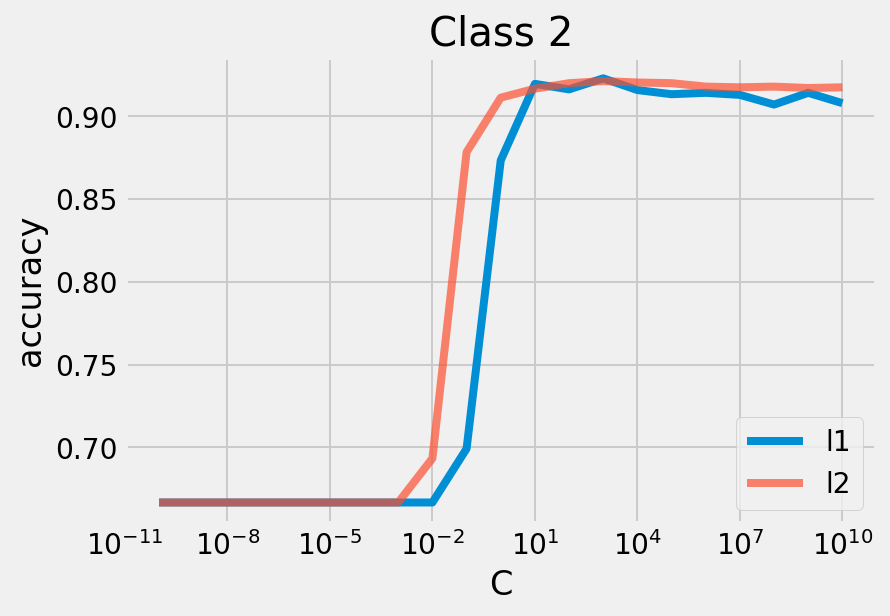

In [37]:
# Comparing the different penalties
for i, cl in enumerate(model_l1.classes_):
    plt.plot(model_l1.Cs_, list(model_l1.scores_.values())[i].mean(axis=0), label='l1')
    plt.plot(model_l2.Cs_, list(model_l2.scores_.values())[i].mean(axis=0), alpha=0.7, label='l2')
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')
    plt.title('Class {}'.format(cl))
    plt.show()

- the accuracy of l2 is generally higher and more stable.

## Gridsearch on Logistic Regression

In [38]:
lr_params = {'penalty': ['l1','l2'],
          'solver':['liblinear'],
          'C': np.logspace(-10,10,21)}

# Define the gridsearchCV
lr_grid = GridSearchCV(lr, param_grid=lr_params, cv=3, n_jobs=-1, verbose=1)

# fit with the tranformed sparse matrix
lr_grid.fit(X_train_cvec_p, y_train)

print('Best Score:', lr_grid.best_score_)

# assign the best estimator to a variable
best_lr = lr_grid.best_estimator_
print('Best Params:', lr_grid.best_params_)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


/home/oleg/Programs/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Best Score: 0.9075000000000001
Best Params: {'C': 10000.0, 'penalty': 'l2', 'solver': 'liblinear'}


# Features importances
- top 10 for each class

In [39]:
pd.DataFrame(best_lr.coef_)
np.argsort(best_lr.coef_)

array([[ 3947, 12059,   248, ..., 12058,  3524,  9136],
       [  248,  9136,  7401, ...,  9832,  3579,  3402],
       [ 3402,  3579,  9136, ...,  3395,  7401,   248]])

In [40]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    
    
    for i, class_label in enumerate(class_labels):
#         output the original index of the top 10 coef
        top10 = np.argsort(clf.coef_[i])[-10:]

        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))

In [41]:
feature_df = pd.DataFrame()
feature_names = cvec_p.get_feature_names()
for i, class_label in enumerate([0,1,2]):
    index = np.argsort(best_lr.coef_[i])
    feature_df['feature_names'] = [feature_names[j] for j in index]
    class_ = best_lr.coef_[i]
    feature_df['class'+str(i)] = np.abs(class_)
        
feature_df.head()

,feature_names,class0,class1,class2
0,difference,0.884512,1.078723,0.039526
1,do,0.460944,0.689382,0.168314
2,pizza,0.460944,0.689382,0.168314
3,disappointment,0.460944,0.689382,0.168314
4,really,0.287450,0.578950,0.273576


In [42]:
class_0_abs_10 = feature_df.sort_values('class0', ascending=False).head(10)
class_1_abs_10 = feature_df.sort_values('class1', ascending=False).head(10)
class_2_abs_10 = feature_df.sort_values('class2', ascending=False).head(10)

0: skip, real dissapointment, dissapointment, small, never, also be, not, thank, disappointment, pizza
1: food be decent, be decent, service be average, average, moderate price, moderate, don get, really, do, difference
2: food, just, try, weren, emilio, thank emilio, classic, die, love, amazing


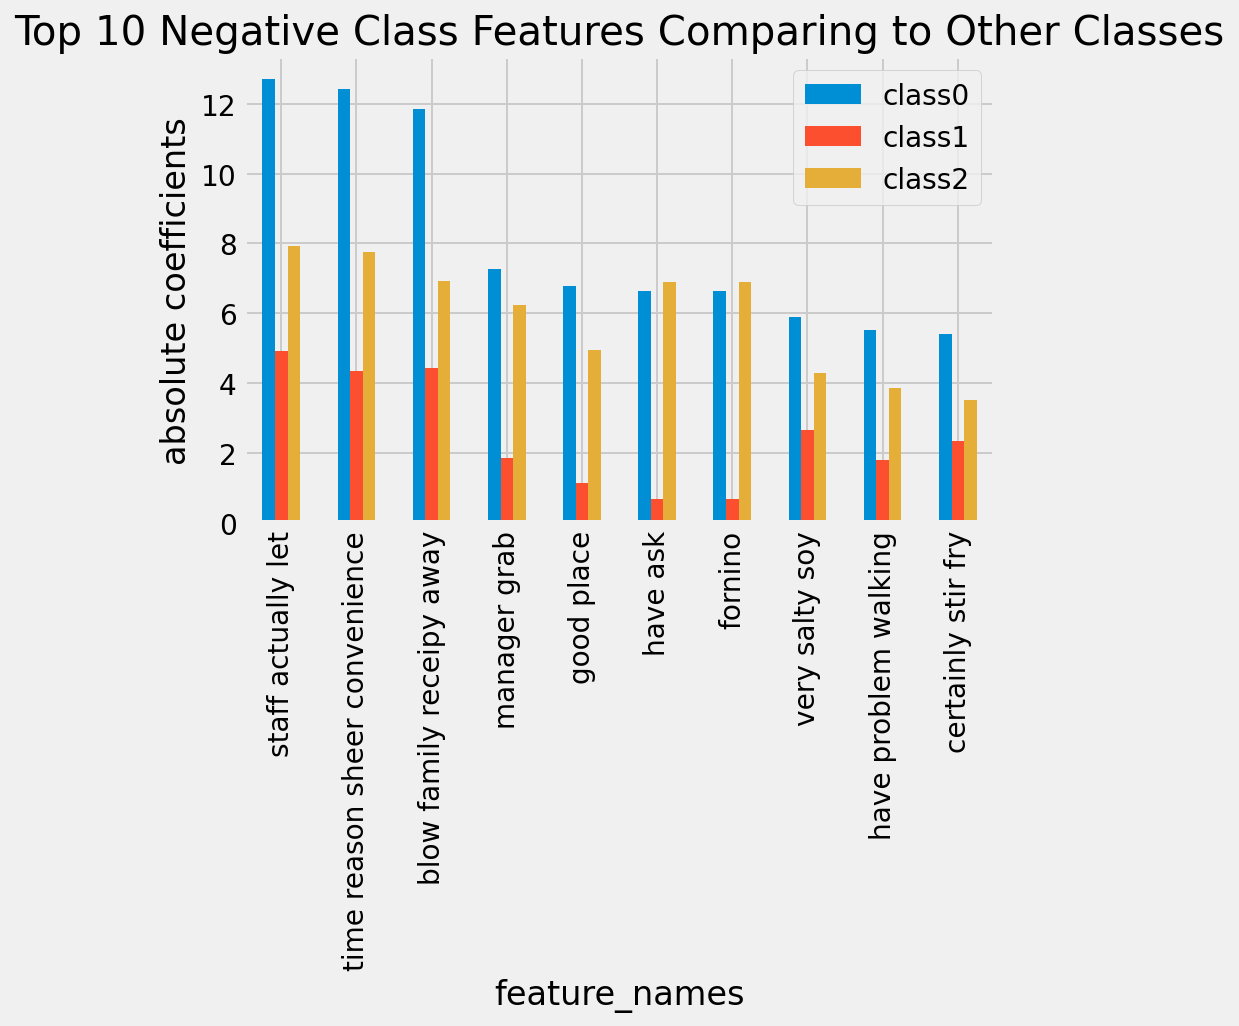

In [43]:
class_0_abs_10.plot(x="feature_names", y=["class0", "class1", "class2"], kind="bar")
plt.ylabel('absolute coefficients')
plt.title('Top 10 Negative Class Features Comparing to Other Classes')
print_top10(cvec_p, best_lr, [0,1,2])

Text(0.5, 1.0, 'Top 10 Neutral Class Features Comparing to Other Classes')

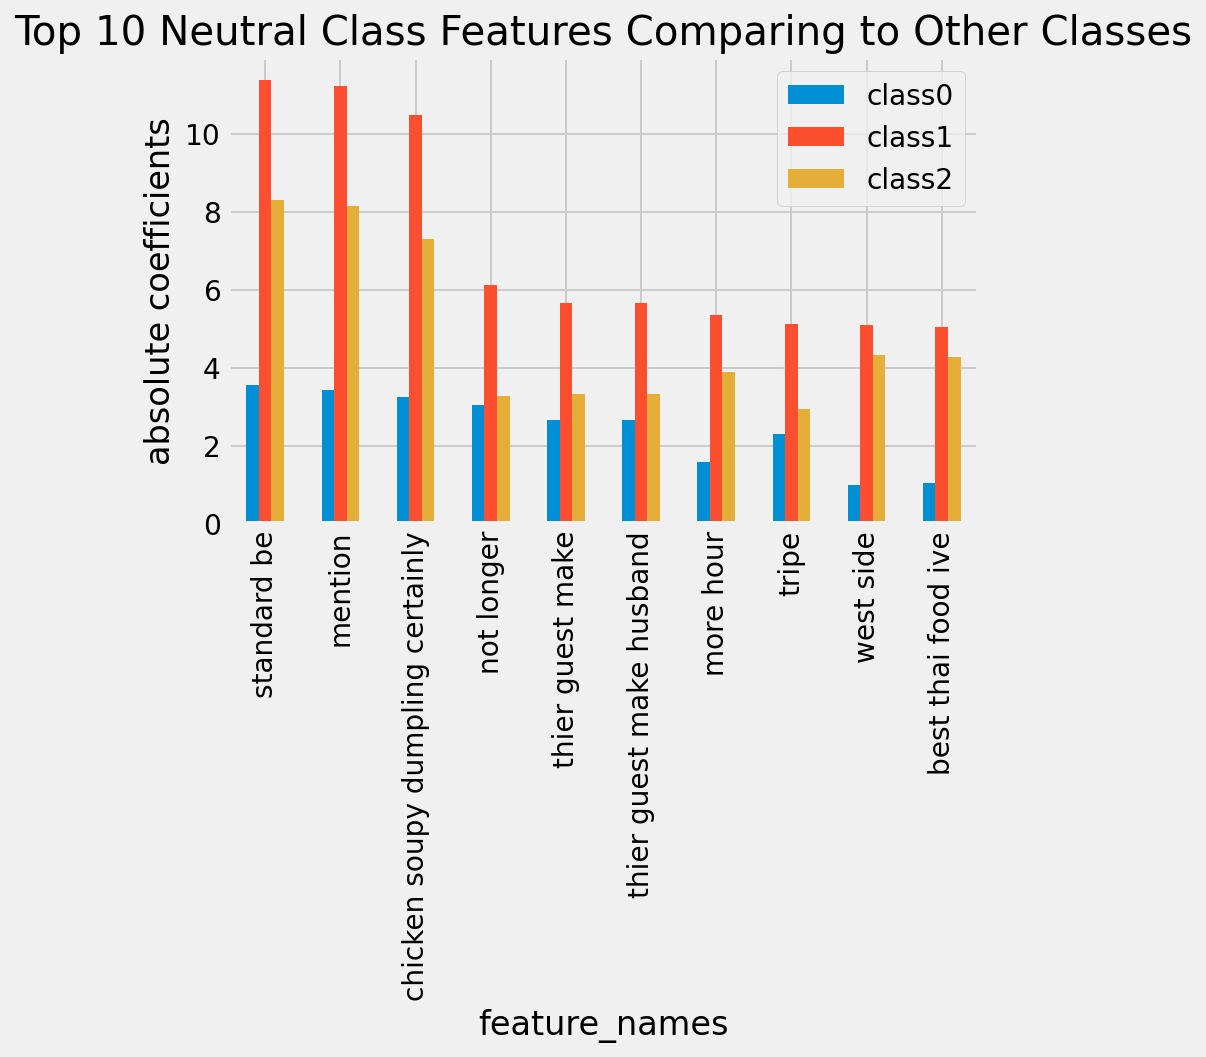

In [44]:

class_1_abs_10.plot(x="feature_names", y=["class0", "class1", "class2"], kind="bar")
plt.ylabel('absolute coefficients')
plt.title('Top 10 Neutral Class Features Comparing to Other Classes')

Text(0.5, 1.0, 'Top 10 Positive Class Features Comparing to Other Classes')

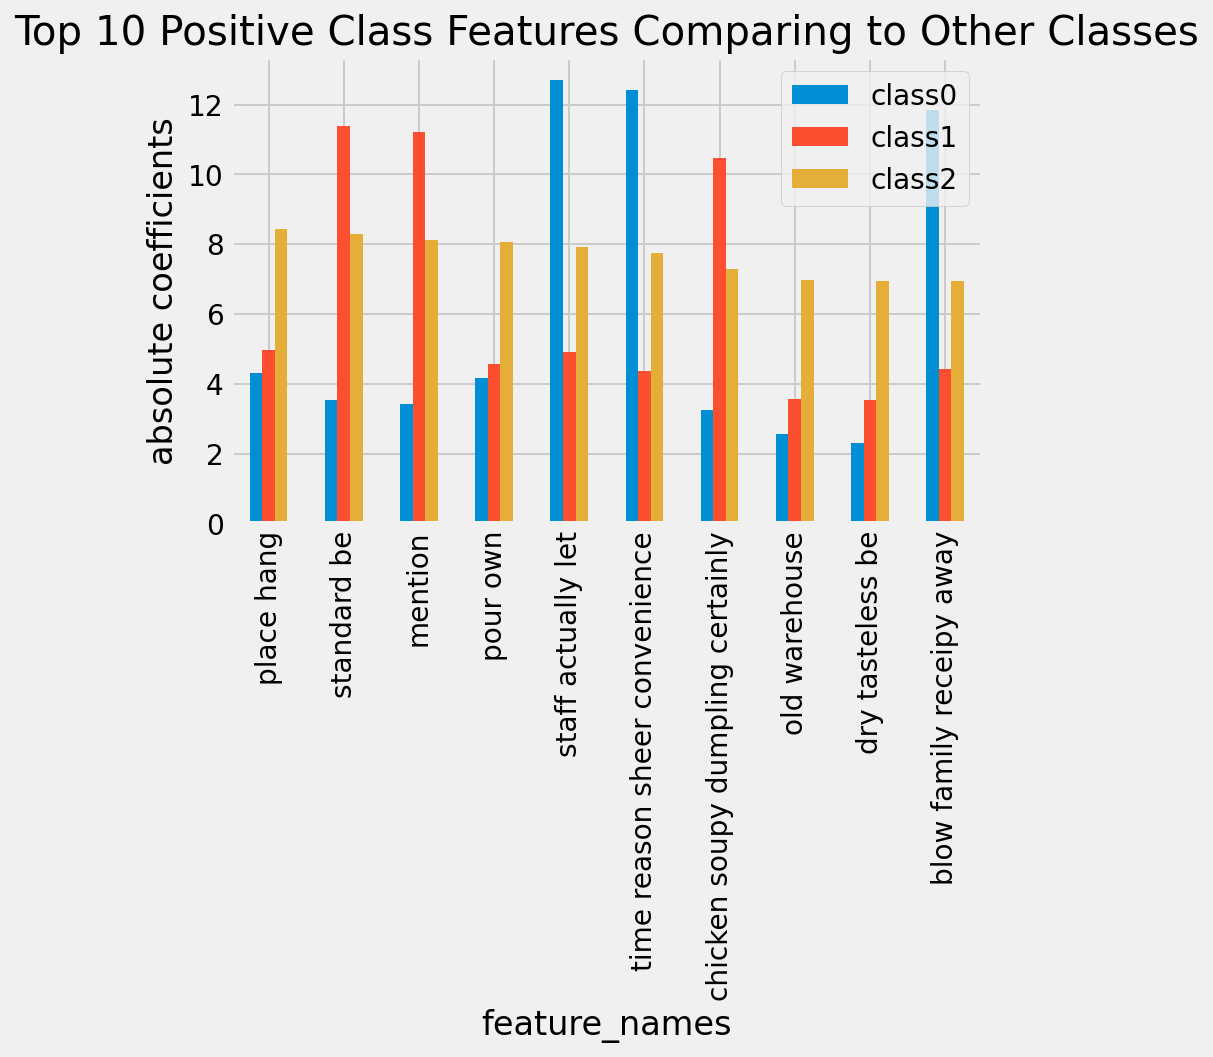

In [45]:
class_2_abs_10.plot(x="feature_names", y=["class0", "class1", "class2"], kind="bar")
plt.ylabel('absolute coefficients')
plt.title('Top 10 Positive Class Features Comparing to Other Classes')

## Evaluation Functions

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



def plot_precision_recall(model,y_bin,X,f1_lines=True):
    precision = {}
    recall = {}

    for i, cl in enumerate(model.classes_):
        precision[cl], recall[cl], _ = metrics.precision_recall_curve(y_bin[:,i],model.predict_proba(X)[:,i])
    
    average_precision_scores = [round(metrics.average_precision_score(y_bin[:,i],model.predict_proba(X)[:,i]),2) for i in range(len(model.classes_))]
    
    plt.figure(figsize=(6,4))
    for i, key in enumerate(precision.keys()):
        plt.plot(precision[key],recall[key],lw = 2, 
                 label='class {}, average precision score {}'.format(key,average_precision_scores[i]))

    plt.ylim([0,1.05])
    plt.legend(loc='lower left')
    plt.title('Precision-Recall Curve',fontsize=20)
    plt.xlabel('Recall',fontsize=18)
    plt.ylabel('Precision',fontsize=18)
    
    if f1_lines == True:
        for const in [0.2,0.4,0.6,0.8]:
            x_vals = np.linspace(0.001,0.999,100)
            y_vals = 1./(2./const-1./x_vals)
            plt.plot(x_vals[y_vals>0],y_vals[y_vals>0],color='lightblue',ls='--',alpha=0.9)
            plt.ylim([0,1])
            plt.annotate('f1={0:0.1f}'.format(const), xy=(x_vals[-10], y_vals[-2]+0.0))

    plt.show()
    
    
    
def plot_roc(model,y_bin,X):
    fpr = {}
    tpr = {}
    for i, cl in enumerate(model.classes_):
        fpr[cl], tpr[cl], _ = metrics.roc_curve(y_bin[:,i],model.predict_proba(X)[:,i])
    auc_scores = [round(metrics.roc_auc_score(y_bin[:,i],model.predict_proba(X)[:,i]),2) for i in range(len(model.classes_))]
    for i, key in enumerate(fpr.keys()):
        plt.plot(fpr[key],tpr[key],lw=2,label='class {}, ROC_AUC {}'.format(key,auc_scores[i]))
    plt.plot([0,1],[0,1],ls='--',lw=2)
    plt.ylim([0,1.05])
    plt.legend(loc='lower right')
    plt.title('ROC Curve',fontsize=20)
    plt.xlabel('FPR',fontsize=18)
    plt.ylabel('TPR',fontsize=18)
    
    plt.show()

## Evaluate using Cross Validation
- Confusion Matrix
- Classification Report
- Precision Recall Curve 
- ROC Curve

Confusion matrix, without normalization
[[741  26  33]
 [ 26 758  16]
 [ 59  35 706]]


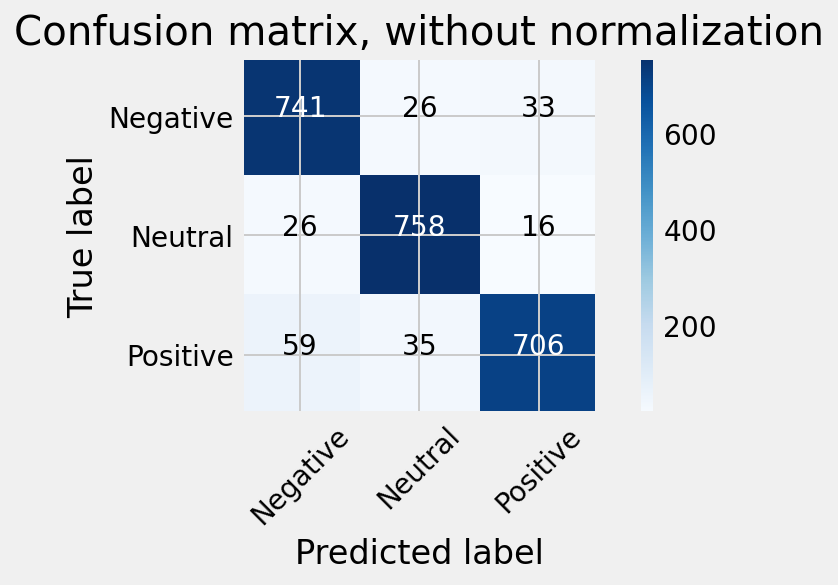

Normalized confusion matrix
[[0.92625 0.0325  0.04125]
 [0.0325  0.9475  0.02   ]
 [0.07375 0.04375 0.8825 ]]


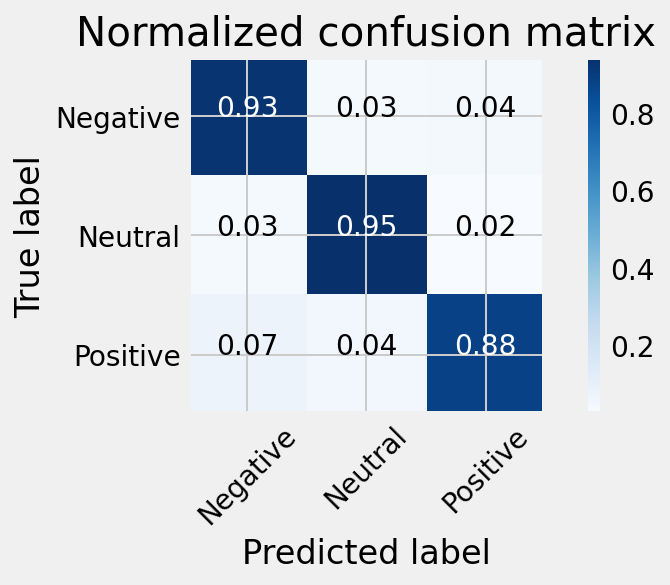

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       800
           1       0.93      0.95      0.94       800
           2       0.94      0.88      0.91       800

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400



In [49]:
predictions_estimator = cross_val_predict(best_lr,X_train_cvec_p,y_train,cv=5)

# Compute confusion matrix
cm_cv = confusion_matrix(y_train,predictions_estimator)
x_class = ['Negative', 'Neutral', 'Positive']

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm_cv, classes=x_class, title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plot_confusion_matrix(cm_cv, classes=x_class, normalize=True, title='Normalized confusion matrix')
plt.show()

print(classification_report(y_train,predictions_estimator))

In [48]:
from sklearn.preprocessing import label_binarize
from sklearn import metrics 
y_bin = label_binarize(y_train,best_lr.classes_)

/home/oleg/Programs/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


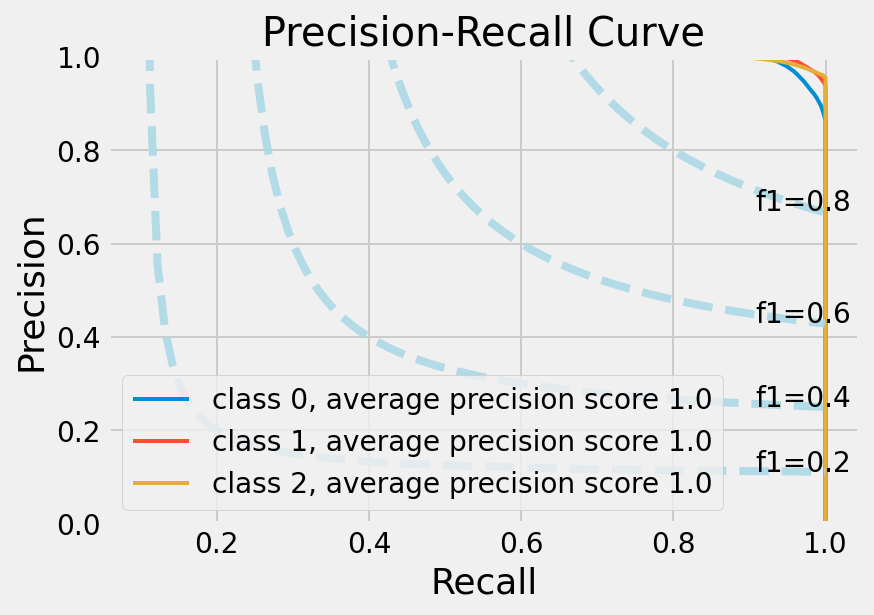

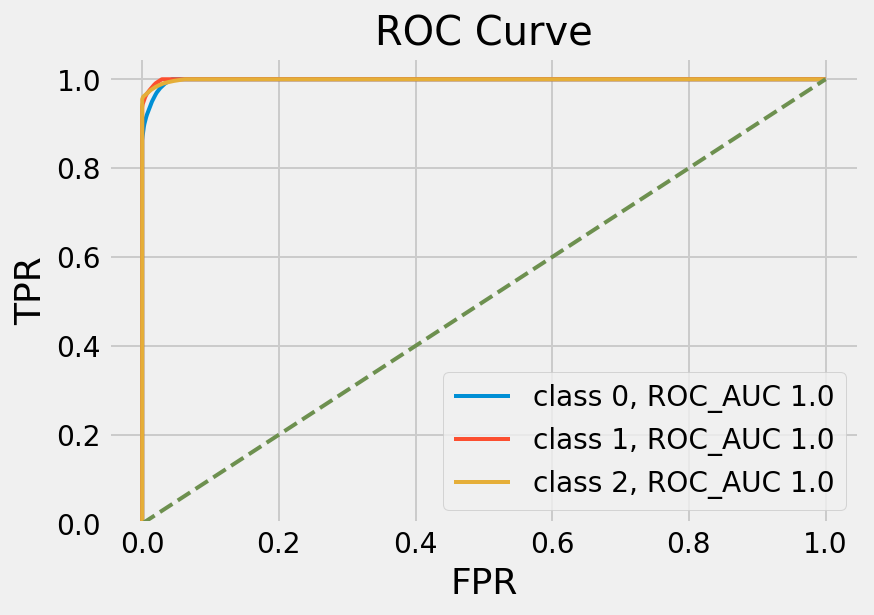

In [50]:
plot_precision_recall(best_lr,y_bin,X_train_cvec_p)
plot_roc(best_lr,y_bin,X_train_cvec_p)

These scores have improved 30% over the baseline

# Evaluate on Test set

In [52]:
testing = pd.read_csv('testing.csv')
testing.head(3)

,sentence,sentiment,lem_words,lem_tags,word_tags
0,They even scoop it out nice (for those on a di...,2,even scoop out nice diet not too much not little,RB VB RB JJ NN RB RB JJ RB JJ,"[even/RB, scoop/VB, out/RB, nice/JJ, diet/NN, ..."
1,We won't go to this place again for a good meal.,0,win go place again good meal,VB VB NN RB JJ NN,"[win/VB, go/VB, place/NN, again/RB, good/JJ, m..."
2,The menu has so many fish items and oysters.,2,menu have so many fish item oyster,NN VB RB JJ JJ NN NN,"[menu/NN, have/VB, so/RB, many/JJ, fish/JJ, it..."


In [53]:
X_test = testing.lem_words
y_test = testing['sentiment']

In [55]:
# transform with cvec and predict on best log reg
X_test_mat = cvec_p.transform(X_test)
y_pred = best_lr.predict(X_test_mat)

print('Best CVal on training:', lr_grid.best_score_)
print('Best Model on testing:', accuracy_score(y_test, y_pred))
print("Number of classification errors:", np.abs(y_pred - y_test).sum())
print('Total:', len(y_test))

Best CVal on training: 0.9075000000000001
Best Model on testing: 0.6100478468899522
Number of classification errors: 247
Total: 418


- The model created had had a high accuracy score of 0.94 
- after scoring on test set it lowered to 0.67 
- which is still significantly higher than the baseline of 0.3
- however shows the model is overfitting on the training data

### Confusions matirix 
- I will evaluate my model through showing the accuracy

Confusion matrix, without normalization
[[ 32  19  37]
 [ 14  21  27]
 [ 47  19 202]]


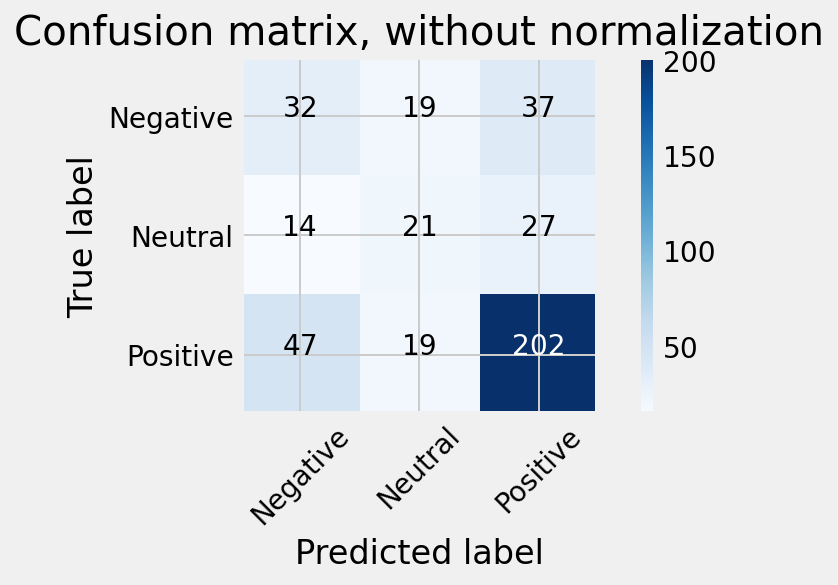

Normalized confusion matrix
[[0.36 0.22 0.42]
 [0.23 0.34 0.44]
 [0.18 0.07 0.75]]


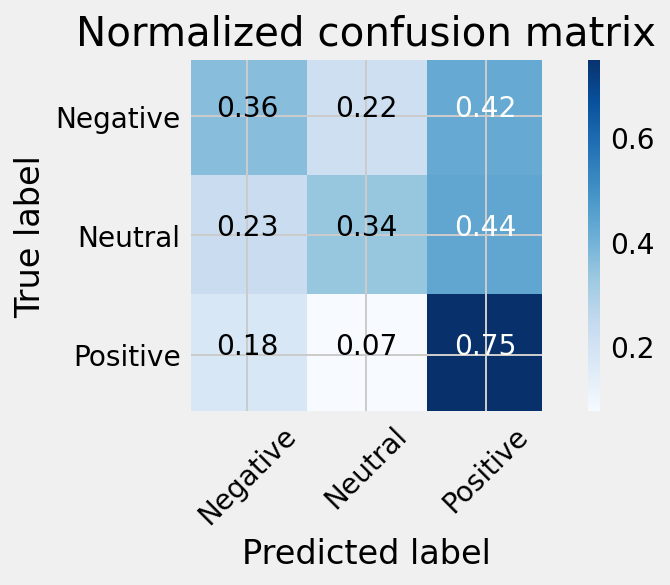

              precision    recall  f1-score   support

           0       0.34      0.36      0.35        88
           1       0.36      0.34      0.35        62
           2       0.76      0.75      0.76       268

    accuracy                           0.61       418
   macro avg       0.49      0.49      0.49       418
weighted avg       0.61      0.61      0.61       418



In [56]:
cm_t = confusion_matrix(y_test,y_pred)
x_class = ['Negative', 'Neutral', 'Positive']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm_t, classes=x_class, title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plot_confusion_matrix(cm_t, classes=x_class, normalize=True, title='Normalized confusion matrix')
plt.show()

print(classification_report(y_test,y_pred))

In comparrison to the Training data 


/home/oleg/Programs/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


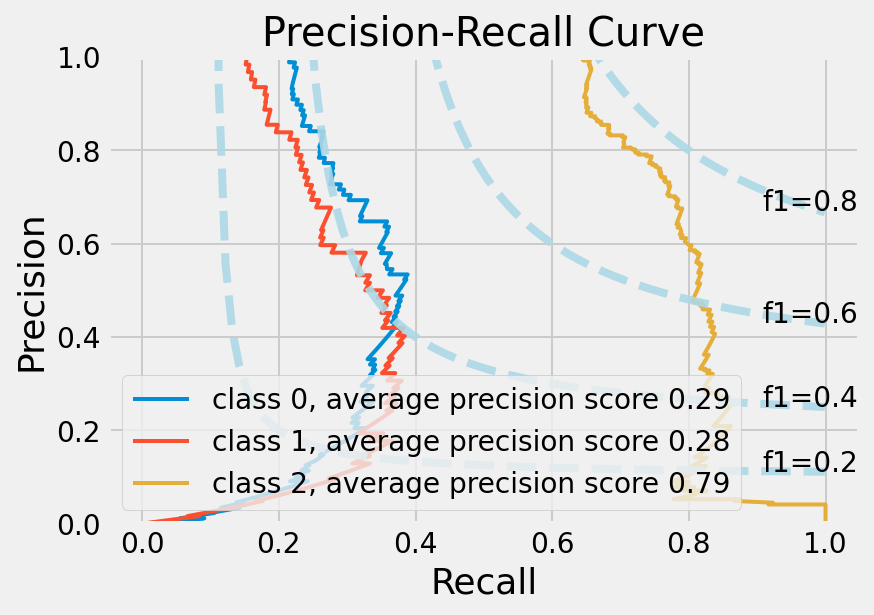

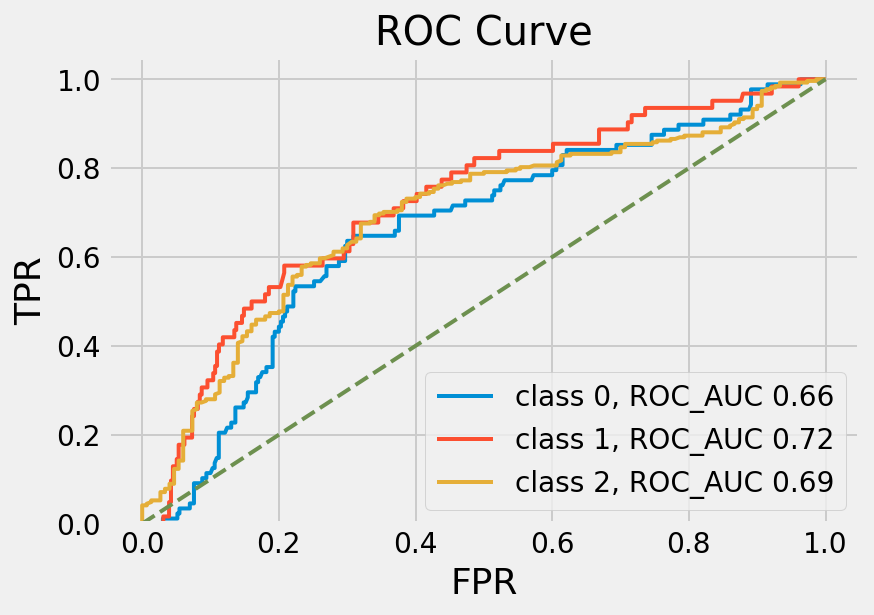

In [57]:
from sklearn.preprocessing import label_binarize
from sklearn import metrics 
y_bin = label_binarize(y_test,best_lr.classes_)

plot_precision_recall(best_lr,y_bin,X_test_mat)
plot_roc(best_lr,y_bin,X_test_mat)

## Foursquare data
    - polarity : Target 2:positive, 1:neutral, 0:negative
    - words : preprocessed sentences
    - type : the tags of the words from lemmatizing 


TFDIF was fitted on the training data which will be used to transfomation the words in testing into a sparse matrix
Logistic Regressions best parameters which were fit for the training data will then predict sentiment (y_hat) for the transformed testing data.



---- logistic regression gave a good score in classifying the predictors but will try different classifiers to determine best accuracy score 


In [60]:
foursquare = pd.read_csv('foursquare_clean.csv', encoding='utf8')
print(foursquare.shape)
foursquare.head(3)

(5176, 6)


,tips,lem_words,lem_tags,word_tags,lng,lat
0,Great fun to be had by everyone. The aquarium ...,great fun be have everyone aquarium be small f...,JJ NN VB VB NN NN VB JJ NN VB NN VB NN NN VB NN,"[great/JJ, fun/NN, be/VB, have/VB, everyone/NN...",51.440982,-0.061369
1,Love this place my new local shop,love place new local shop,VB NN JJ JJ NN,"[love/VB, place/NN, new/JJ, local/JJ, shop/NN]",51.466901,0.052826
2,Enter our prize draw to win a family ticket to...,prize draw win family ticket sea life don win ...,NN NN VB NN NN NN NN VB VB RB VB RB VB JJ NN V...,"[prize/NN, draw/NN, win/VB, family/NN, ticket/...",51.501711,-0.119767


In [61]:
X = foursquare.lem_words

# transform with chosen cvec and predict on best log reg
X_fs_mat = cvec_p.transform(X)
y_fs_pred = best_lr.predict(X_fs_mat)

foursquare['polarity_pred'] = y_fs_pred
foursquare.head(3)

,tips,lem_words,lem_tags,word_tags,lng,lat,polarity_pred
0,Great fun to be had by everyone. The aquarium ...,great fun be have everyone aquarium be small f...,JJ NN VB VB NN NN VB JJ NN VB NN VB NN NN VB NN,"[great/JJ, fun/NN, be/VB, have/VB, everyone/NN...",51.440982,-0.061369,2
1,Love this place my new local shop,love place new local shop,VB NN JJ JJ NN,"[love/VB, place/NN, new/JJ, local/JJ, shop/NN]",51.466901,0.052826,2
2,Enter our prize draw to win a family ticket to...,prize draw win family ticket sea life don win ...,NN NN VB NN NN NN NN VB VB RB VB RB VB JJ NN V...,"[prize/NN, draw/NN, win/VB, family/NN, ticket/...",51.501711,-0.119767,0


In [65]:
print('Accuracy Score of Model which reflect on New Data Predictions')
print('Best CVal on training:', lr_grid.best_score_)
print('Best Model on testing:', accuracy_score(y_test, y_pred))
print("Number of classification errors:", np.abs(y_pred - y_test).sum())
print('Total:', len(y_test))

Accuracy Score of Model which reflect on New Data Predictions
Best CVal on training: 0.9075000000000001
Best Model on testing: 0.6100478468899522
Number of classification errors: 247
Total: 418


## Save Foursquare Predictions

In [66]:
foursquare.to_csv('foursquare_predictions.csv', header=True, index=False, encoding='UTF8')

df_neutral= foursquare[foursquare.polarity_pred ==1]
df_positive= foursquare[foursquare.polarity_pred ==2]
df_negative= foursquare[foursquare.polarity_pred ==0]

# created to make graphs on tableau
df_neutral.to_csv('df_neutral.csv', header=True, index=False, encoding='UTF8')
df_positive.to_csv('df_positive.csv', header=True, index=False, encoding='UTF8')
df_negative.to_csv('df_negative.csv', header=True, index=False, encoding='UTF8')

# Visualisations 

In [67]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [68]:
foursquare.groupby(['polarity_pred']).count()

,tips,lem_words,lem_tags,word_tags,lng,lat
polarity_pred,,,,,,
0,591,591,591,591,591,591
1,791,791,791,791,791,791
2,3794,3794,3794,3794,3794,3794


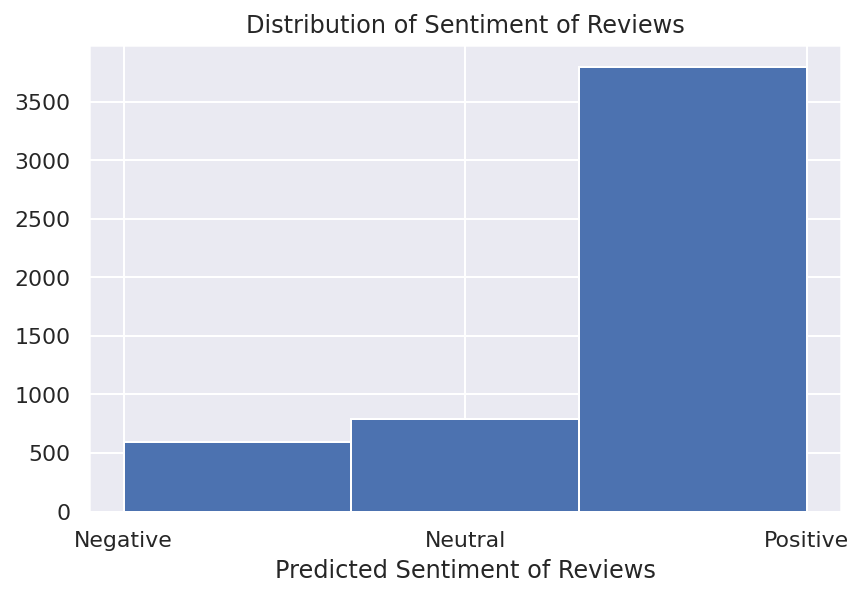

In [69]:
plt.hist(foursquare.polarity_pred, bins = 3, align= 'mid')
plt.xticks(range(3), ['Negative','Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment of Reviews')
plt.title('Distribution of Sentiment of Reviews')
plt.show()